# 5. Modeling - Term Deposit Subscription

## Contents
- 5.1 [Introduction](#5.1.Introduction)
- 5.2 [Initial Model Exploration](#5.2.ModelExploration)
- 5.3 [Model Selection](#5.3.ModelSelection)
- 5.4 [Hyperparameter Tuning](#5.4.HyperparameterTuning)
- 5.5 [Final Model Training](#5.5.FinalModel)
- 5.6 [Final Model Evaluation](#5.6.ModelEvaluation)
- 5.7 [Conclusion and Reccomendation](#5.7Conclusion)


### 5.1 Introduction <a id="5.1.Introduction"></a>

First, I'll begin by exploring 5 models and compare the results at baseline. Then after comparing various evaluation metrics, the model with the best metrics will be selected. Then follows the hyperparameter tuning on the best classifier using Randomized search. Once the best hyperparameters are revealed, the final model will be built and evaluated.

In [180]:
#importing relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,  f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score


import warnings
warnings.filterwarnings("ignore")

In [3]:
X_train = pd.read_csv('X_train_subscription.csv')
X_test = pd.read_csv('X_test_subscription.csv')

y_train = pd.read_csv('y_train_subscription.csv')
y_test = pd.read_csv('y_test_subscription.csv')

### 5.2 Initial Model Exploration  <a id="5.2.ModelExploration"></a>  

With this step, I'll try to gether insights into how different algorithms behave with the dataset to get a baseline understanding of model performance before diving into more complex optimizations. 
Because the dataset is highly imbalanced, the parameter `class_weight` will be set to `'balanced'` for all classifiers.

In [144]:
# list of models

models = [KNeighborsClassifier(n_neighbors=2),
          LogisticRegression(class_weight='balanced'),
          RandomForestClassifier(class_weight='balanced'),
          GradientBoostingClassifier(),
          SVC(class_weight='balanced')]

In [145]:
def compare_classifiersCV():
    
    for model in models:
        cv_score = cross_val_score(model, X_train, y_train, cv=5)
        mean_accuracy = sum(cv_score)/len(cv_score)
        mean_accuracy = round((mean_accuracy*100), 2)
        
        y_pred = cross_val_predict(model, X_train, y_train, cv=5)
        balanced_accuracy = balanced_accuracy_score(y_train, y_pred)
        balanced_accuracy = round((balanced_accuracy *100), 2)
        
        y_pred = cross_val_predict(model, X_train, y_train, cv=5)
        f1 = f1_score(y_train, y_pred)
        f1 = round((f1), 2)
        
        y_scores = cross_val_predict(model, X_train, y_train, cv=5, method="predict")
        auc_score = roc_auc_score(y_train, y_scores)
        auc_score = round((auc_score), 2)
        
        cm = confusion_matrix(y_train, y_pred)
        
        print('Cross Validation accuracies for the', model, '=', cv_score)
        print('Accuracy score of the' , model, '=', mean_accuracy, '%')
        print('Balanced Accuracy score of the' , model, '=', balanced_accuracy, '%')
        print('F1 score of the', model, '=', f1)
        print('AUC score of the', model, '=', auc_score)
        print('Confusion Matrix of the', model, '=\n', cm)
        
        print('_____________________________________________________________')
        

In [146]:
compare_classifiersCV()

Cross Validation accuracies for the KNeighborsClassifier(n_neighbors=2) = [0.89007634 0.89251908 0.88870229 0.89129771 0.89068702]
Accuracy score of the KNeighborsClassifier(n_neighbors=2) = 89.07 %
Balanced Accuracy score of the KNeighborsClassifier(n_neighbors=2) = 58.1 %
F1 score of the KNeighborsClassifier(n_neighbors=2) = 0.27
AUC score of the KNeighborsClassifier(n_neighbors=2) = 0.58
Confusion Matrix of the KNeighborsClassifier(n_neighbors=2) =
 [[28500   560]
 [ 3021   669]]
_____________________________________________________________
Cross Validation accuracies for the LogisticRegression(class_weight='balanced') = [0.82519084 0.83129771 0.83022901 0.82564885 0.82396947]
Accuracy score of the LogisticRegression(class_weight='balanced') = 82.73 %
Balanced Accuracy score of the LogisticRegression(class_weight='balanced') = 81.37 %
F1 score of the LogisticRegression(class_weight='balanced') = 0.51
AUC score of the LogisticRegression(class_weight='balanced') = 0.81
Confusion Matri

### 5.3 Model selection    <a id="5.3.ModelSelection"></a> 

Looking solely at the accuracy metric results from the 5 models, it seems like Gradient Boosting model and Random Forest model out perform the other two. However,the rest of the metrics measured(i.e. Balanced accuracy, confusion metrics, F1 score and auc score) all show that these two models may not really be the best models in that they exhibit a high number of False negative than the rest.
This means,  because the dataset is highly imbalanced with more negative classes(customers not subscribing), the model is simply predicting more negatives than positive classes, indicating that the model isn't really learning the underlying relationship with the target variable. 
Therefore, Logistic regression and Support Vector Classifier are identified as the better classifiers for this classification problem.

### 5.4 Hyperparameter tuning <a id="5.4.HyperparameterTuning"></a>

#### 5.4. a. Logistic Regression

In [61]:
param = {
    'C': [1.0, 1.0, 5.0, 10.0],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [50, 100, 150, 200],
    'warm_start' : [True, False]
             }

lr =  LogisticRegression(class_weight='balanced')

lr_cv= RandomizedSearchCV(lr,param,cv=5)
lr_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
                   param_distributions={'C': [1.0, 1.0, 5.0, 10.0],
                                        'max_iter': [50, 100, 150, 200],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga'],
                                        'warm_start': [True, False]})

In [63]:
print("Best Score:" + str(lr_cv.best_score_))
print("Best Parameters: " + str(lr_cv.best_params_))

Best Score:0.8272671755725192
Best Parameters: {'warm_start': True, 'solver': 'lbfgs', 'max_iter': 100, 'C': 1.0}


In [64]:
y_pred = cross_val_predict(lr, X_train, y_train, cv=5)
balanced_accuracy = balanced_accuracy_score(y_train, y_pred)
print("Balanced Accuracy: " , round(balanced_accuracy,2))

Balanced Accuracy:  0.81


In [65]:
f1 = f1_score(y_train, y_pred)
f1 = round((f1), 2)
print("F1 Score: ", f1)

F1 Score:  0.51


In [66]:
auc_score = roc_auc_score(y_train, y_pred)
auc_score = round((auc_score), 2)
print("AUC Score: ", auc_score)

AUC Score:  0.81


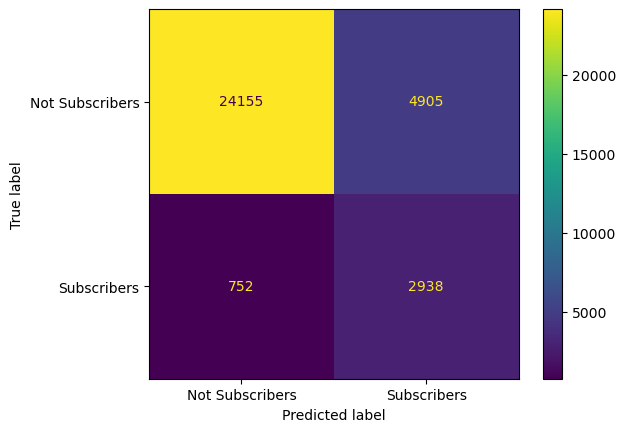

In [67]:
cm = confusion_matrix(y_train, y_pred)
class_names = ['Not Subscribers', 'Subscribers']

p = ConfusionMatrixDisplay(cm, display_labels = class_names)
p.plot()

In [71]:
report = classification_report(y_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.83      0.90     29060
           1       0.37      0.80      0.51      3690

    accuracy                           0.83     32750
   macro avg       0.67      0.81      0.70     32750
weighted avg       0.90      0.83      0.85     32750



#### 5.4. b. Support Vector Classifier

In [27]:
param = {
    'C': [0.1, 1, 10, 50] ,
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'shrinking': [True],
    'probability': [True],
    'class_weight': ['balanced']
             }

svc =  SVC(class_weight='balanced')

svc_cv= RandomizedSearchCV(svc,param,cv=5)
svc_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
                   param_distributions={'C': [0.1, 1, 10, 50],
                                        'class_weight': ['balanced'],
                                        'kernel': ['poly', 'rbf', 'sigmoid'],
                                        'probability': [True],
                                        'shrinking': [True]})

In [28]:
print("Best Score:" + str(svc_cv.best_score_))
print("Best Parameters: " + str(svc_cv.best_params_))

Best Score:0.8388091603053436
Best Parameters: {'shrinking': True, 'probability': True, 'kernel': 'poly', 'class_weight': 'balanced', 'C': 1}


In [43]:
y_pred_svc = cross_val_predict(svc, X_train, y_train, cv=5)
balanced_accuracy = balanced_accuracy_score(y_train, y_pred)
print(round(balanced_accuracy,2))

0.81


In [44]:
f1 = f1_score(y_train, y_pred_svc)
f1 = round((f1), 2)
print(f1)

0.52


In [45]:
auc_score = roc_auc_score(y_train, y_pred_svc)
auc_score = round((auc_score), 2)
print(auc_score)

0.83


In [46]:
cm_svc = confusion_matrix(y_train, y_pred_svc)
cm

array([[24155,  4905],
       [  752,  2938]], dtype=int64)

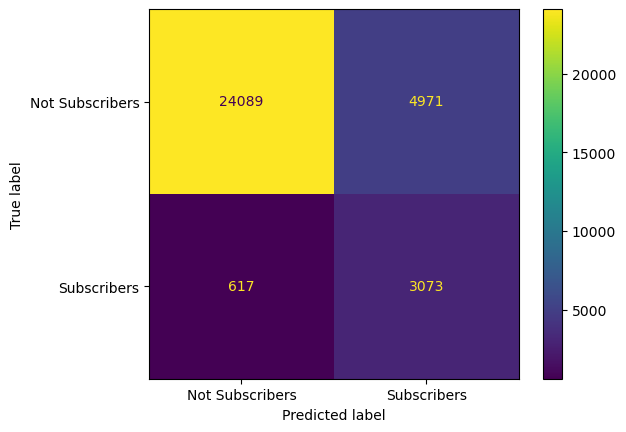

In [47]:
cm_svc = confusion_matrix(y_train, y_pred_svc)
class_names = ['Not Subscribers', 'Subscribers']

p = ConfusionMatrixDisplay(cm_svc, display_labels = class_names)
p.plot()

In [70]:
report = classification_report(y_train, y_pred_svc)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     29060
           1       0.38      0.83      0.52      3690

    accuracy                           0.83     32750
   macro avg       0.68      0.83      0.71     32750
weighted avg       0.91      0.83      0.85     32750



The hyperparameter Tuning did not significantly increase the models' score, the main difference in the performance of the models was achieved by setting 'class_weight' to 'balance'.

Comparing the Logistic Regression classifier with the Support Vector Classifier, both have the same level of balanced accuracy but the support vector classifier has a slightly higher AUC and F1 score. However, training and prediction using the `support vector classifier` requires a significant amount of time. Moreover, the `logistic regression model` results in interpretable coefficients. Therefore, the Logistic Regression model is selected for this project. 

### 5.5 Final Model Training <a id="5.5.FinalModel"></a>

In [78]:
log_reg=  LogisticRegression( C = 1.0,  max_iter = 100, solver = 'lbfgs', class_weight='balanced', warm_start = True)


log_reg.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', warm_start=True)

In [94]:
coefficients = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index)
coefficients

,Feature,Coefficient,AbsoluteCoefficient
27,previous_outcome_success,2.366973,2.366973
25,contact_type_unknown,-1.359542,1.359542
4,duration,1.285004,1.285004
22,housing,-0.910418,0.910418
28,previous_outcome_unknown,-0.737155,0.737155
15,job_student,0.677024,0.677024
23,loan,-0.630698,0.630698
10,job_housemaid,-0.561755,0.561755
8,job_blue-collar,-0.524837,0.524837
9,job_entrepreneur,-0.475847,0.475847


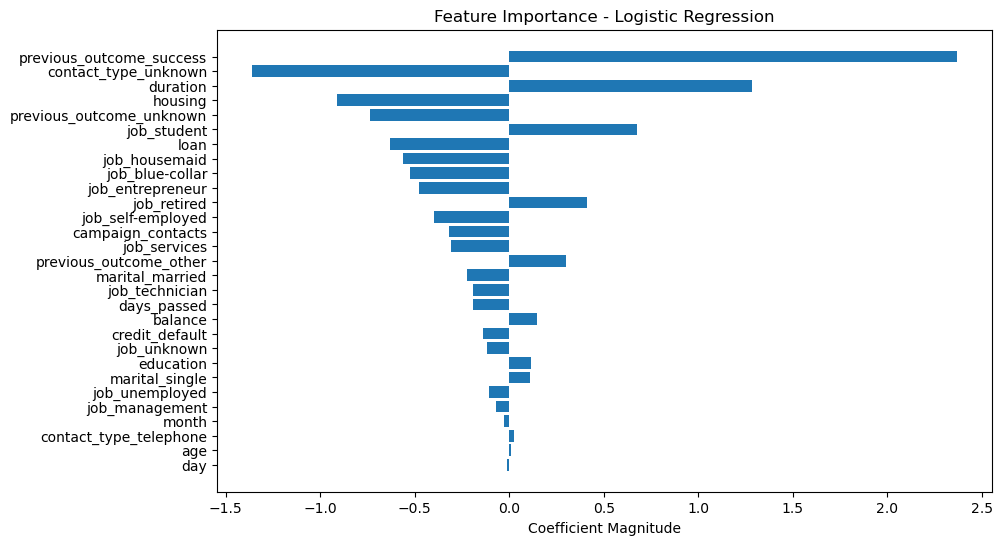

In [95]:
coefficients = coefficients.sort_values(by='AbsoluteCoefficient')

plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance - Logistic Regression')
plt.show()

* The top features that the model showed to have the biggest impact are: `previous_outcome_success(+ve)`, `contact_type_unknown(-ve)`, `duration(+ve)` and `housing loan`.

* Different job types show different effect on subscription. While being a `student` and being `retired` increase the tendancy of a customer to subscribe to term deposits, being `housemaid`, `blue-collar` and `entrepreneur` decreases the tendency of the customer to subscribe. Which is consistent to the results of the Explroratory Data Analysisi results.

* `Month` and `day` of contact showed to have the least impact on subscription along with age of the customer.

### 5.6 Final Model Evaluation <a id="5.6.ModelEvaluation"></a>

In [229]:
y_probs = log_reg.predict_proba(X_test)[:, 1] 

threshold = 0.55

y_pred_ = [1 if prob >= threshold else 0 for prob in y_probs]

f1 = f1_score(y_test, y_pred_)
print(f"F1 score with threshold {threshold}: {round(f1, 2)}")

F1 score with threshold 0.55: 0.52


In [230]:
accuracy = accuracy_score(y_test, y_pred_)
precision = precision_score(y_test, y_pred_)
recall = recall_score(y_test, y_pred_)

print("Accuracy : ", round(accuracy, 2))
print("Precision : ", round(precision, 2))
print("Recall : ", round(recall, 2))


Accuracy :  0.85
Precision :  0.4
Recall :  0.74


In [231]:
report_ = classification_report(y_test, y_pred_)
print(report_)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      9717
           1       0.40      0.74      0.52      1200

    accuracy                           0.85     10917
   macro avg       0.68      0.80      0.71     10917
weighted avg       0.90      0.85      0.87     10917



In [232]:
auc_roc = roc_auc_score(y_test, y_pred_)
print("AUC-ROC Score:", round(auc_roc, 2))

AUC-ROC Score: 0.8


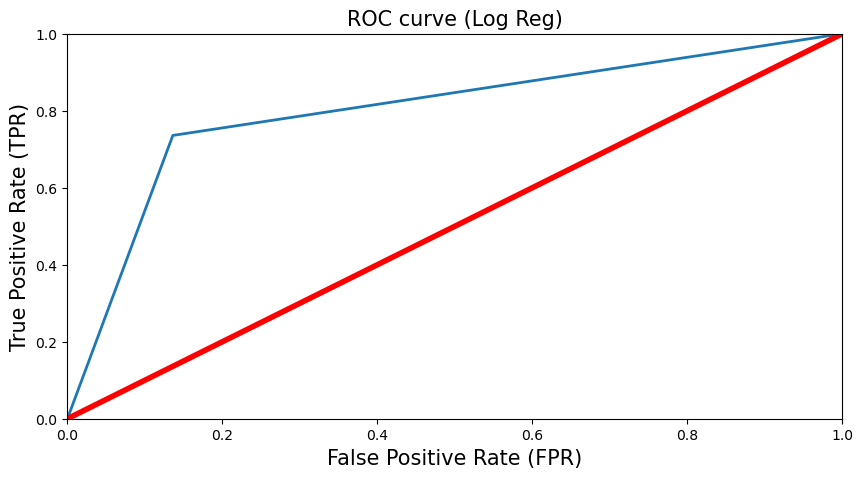

In [233]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (Log Reg)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(fpr, tpr)
plt.show()

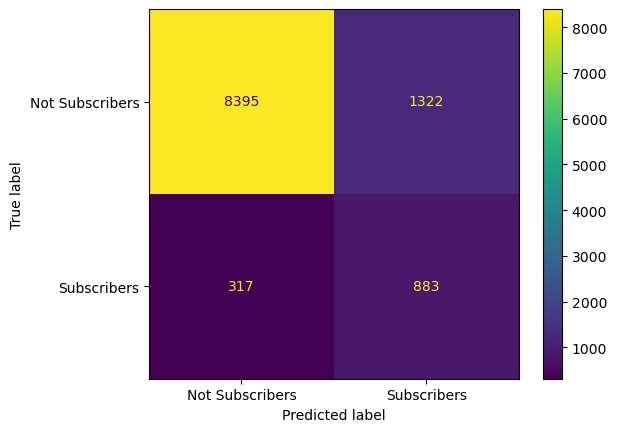

In [234]:
cm_log_reg = confusion_matrix(y_test, y_pred_)
class_names = ['Not Subscribers', 'Subscribers']

disp = ConfusionMatrixDisplay(cm_log_reg, display_labels = class_names)
disp.plot()

### 5.7 Conclusion and Recommendation  <a id="5.7Conclusion"></a> 

**Conclusion:**


* From the initial model exploration the accuracy metric indicated that Gradient Boosting and Random Forest models performed better than others. However, further evaluation metrics like balanced accuracy, confusion matrix, F1 score, and AUC suggested otherwise due to a high number of False Negatives in these models. And identified Logistic Regression and Support Vector Classifier (SVC) as better options for this imbalanced dataset due to their performance in handling the imbalance.

* Hyperparameter tuning was conducted, which didn’t significantly improve model performance. 

* Model Comparison between Logistic Regression and SVC: 
Found that both Logistic Regression and SVC had similar balanced accuracy, but SVC showed slightly higher AUC and F1 scores. However, training and prediction with SVC took significantly more time compared to Logistic Regression. Finally, Logistic Regression was selected due to its interpretable coefficients and reasonable performance metrics.

* Identified key features impacting the model the most: 
'previous_outcome_success' (positive), 'contact_type_unknown' (negative), 'duration' (positive), and 'housing loan'.
Different job types had varied effects on subscription, aligning with the exploratory data analysis results - i.e. being a student or retired increased subscription tendency, while being a housemaid, blue-collar worker, or entrepreneur decreased it.
Month and Day of contact, along with the age of the customer, had minimal impact on subscription according to the model.

* `contact_type_unknown` was shown to have a significant negative impact on subscription - recalling that a very significant portion of the feature contact_type had the value 'unknown', this association could be considered incorrect. The model might have incorrectly associated this feature's dominance with the target variable, and assume a strong relationship between them only due to the model's bias towards the majority class within this highly imbalanced feature.


**Recommendations:**

* Considering the imbalanced dataset, Logistic Regression appeared as the preferred model due to its interpretability, reasonable performance metrics, and quicker training/prediction times compared to SVC. However, further analysis or feature engineering might be required to enhance the model's performance, especially in handling the imbalanced nature of the data and improving predictive capabilities.

* To mitigate the issue of having incorrect coefficient of `contact_type_unknown`, we could use consider removing this feature from the training set.

* The threshold for prediction can be adjusted (lowered) to allow the model to capture more positive instances, potentially reducing missed positive cases which could enable the bank to maximize efforts in targeting more customers leading to a higher potential subscription. Similarly, the threshold can be increased to make the model more conservative in classifying instances as positive allowing the bank to use less resources in the campaign and focus on a smaller number of customers that are highly likely to subscribe. The decision to adjust this threshold depends on the bank's Subscription goals for future campaigns.